<a href="https://colab.research.google.com/github/badjie90/BRAIN-TUMOR-CLASSIFICATION-USING-CONVOLUTIONAL-NEURAL-NETWORK/blob/main/MRI_BRAIN_TUMOR_CLASSIFICATION_USING_CONVOLUTIONAL_NEURAL_NETWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/MyDrive/Brain_MRI


/content/drive/.shortcut-targets-by-id/1bRtRuVxeot2nYQMoOUg3XKpfZ4dP-dRU/Brain_MRI


#### Load the data containing path to our Brain MRI dataset with their corresponding mask

In [ ]:
brain_df = pd.read_csv('data_mask.csv')
brain_df.head(100)

patient_id  ... mask
0   TCGA_CS_5395_19981004  ...    0
1   TCGA_CS_5395_19981004  ...    0
2   TCGA_CS_5395_19981004  ...    0
3   TCGA_CS_5395_19981004  ...    0
4   TCGA_CS_5395_19981004  ...    0
..                    ...  ...  ...
95  TCGA_CS_5396_20010302  ...    0
96  TCGA_CS_5396_20010302  ...    0
97  TCGA_CS_5396_20010302  ...    0
98  TCGA_CS_5396_20010302  ...    0
99  TCGA_CS_5396_20010302  ...    0

[100 rows x 4 columns]

In [ ]:
brain_df_copy = brain_df.copy()

In [ ]:
brain_df_copy.head()

patient_id  ... mask
0  TCGA_CS_5395_19981004  ...    0
1  TCGA_CS_5395_19981004  ...    0
2  TCGA_CS_5395_19981004  ...    0
3  TCGA_CS_5395_19981004  ...    0
4  TCGA_CS_5395_19981004  ...    0

[5 rows x 4 columns]

In [ ]:
brain_df_copy.shape

(3929, 4)

In [ ]:
my_data = [brain_df, brain_df_copy]

In [ ]:
brain_df1 = pd.concat(my_data)
brain_df1.shape

(7858, 4)

In [ ]:
brain_df1.head()

patient_id  ... mask
0  TCGA_CS_5395_19981004  ...    0
1  TCGA_CS_5395_19981004  ...    0
2  TCGA_CS_5395_19981004  ...    0
3  TCGA_CS_5395_19981004  ...    0
4  TCGA_CS_5395_19981004  ...    0

[5 rows x 4 columns]

## PERFORMING DATA VISUALIZATION

In [ ]:
# Checking if the data contain null values
brain_df1.isnull().sum()

patient_id    0
image_path    0
mask_path     0
mask          0
dtype: int64

In [ ]:
brain_df1.image_path # MRI Image paths

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 7858, dtype: object

In [ ]:
brain_df1.mask_path # Mask Paths

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 7858, dtype: object

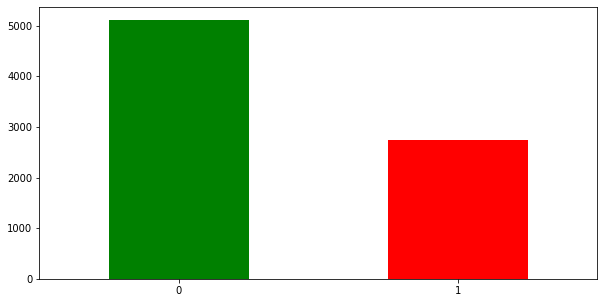

In [ ]:
# Visualize the healthy and unhealthy image on a bar plot
brain_df1['mask'].value_counts().plot(kind = 'bar', color = ('green', 'red'), figsize = (10,5))
plt.xticks(rotation = 0)
plt.show()

### Let's Visualize the images (MRI and Mask) in the dataset separately. That is, visualizing the MRI images with their corresponding mask 

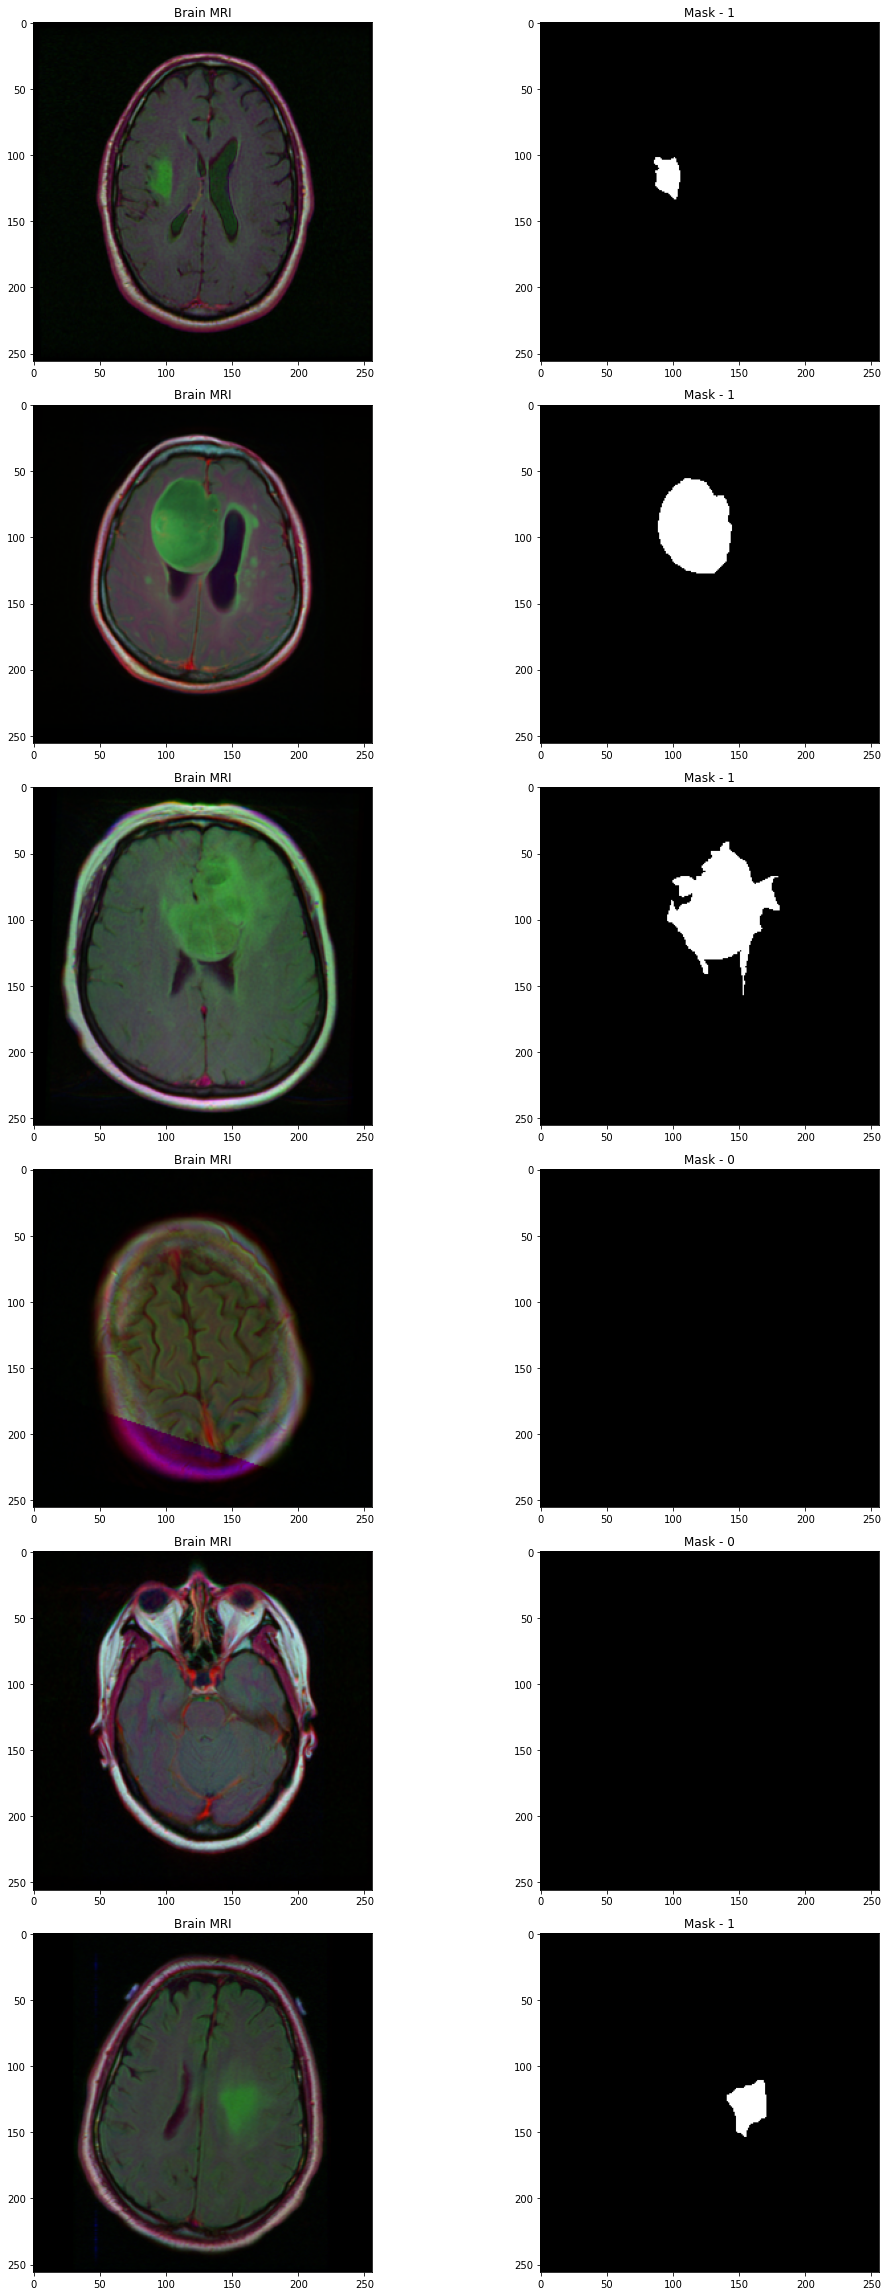

In [ ]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

* Now let's plot 12 randomly selected MRI scan images from only sick patients followed by their corresponding mask, and show both MRI image and the corresponding mask (in red color) on top of each other

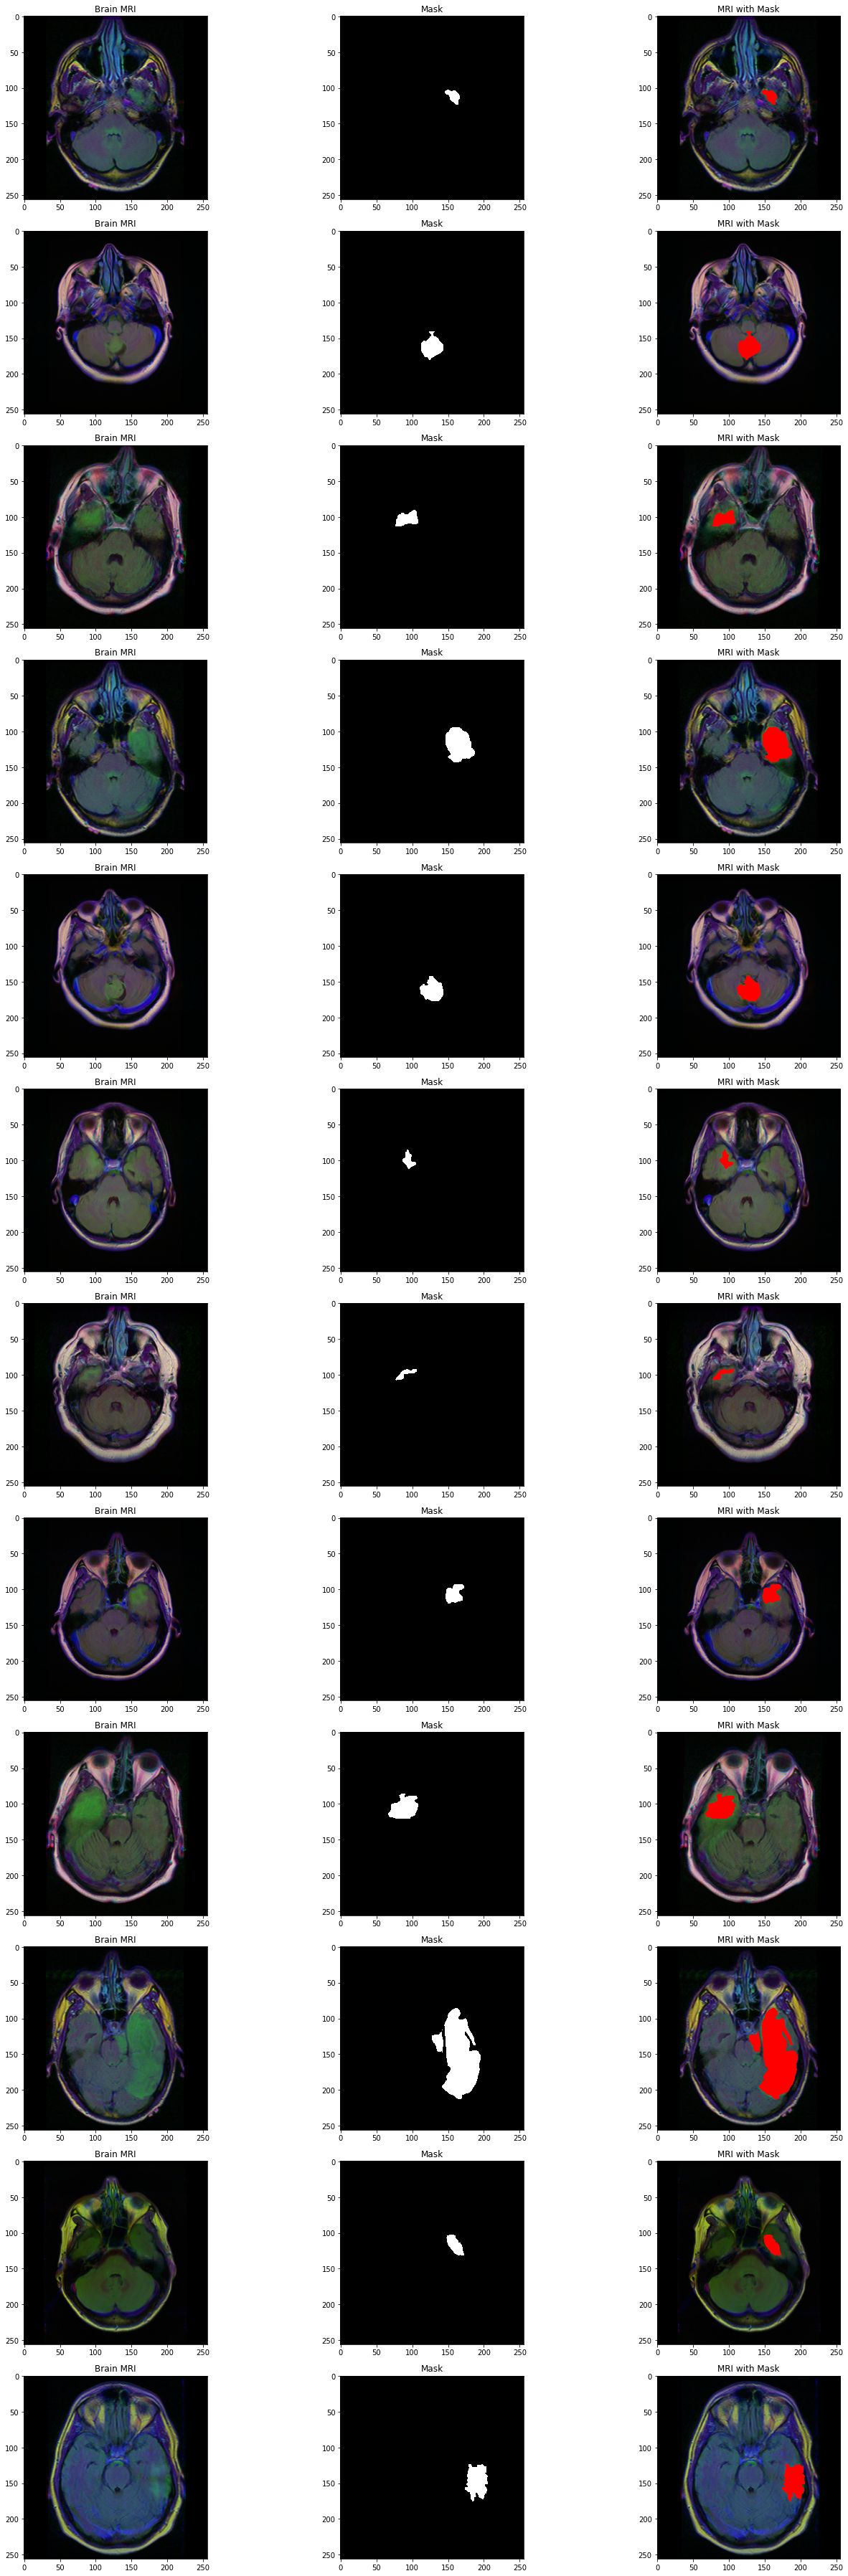

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


# PERFORMING CONVOLUTIONAL NEURAL NETWORK AND TRANSFER LEARNING USING ALEXNET MODEL

### LET'S TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT IN THE BRAIN

In [ ]:
# Let's drop the patient id column since it is not relevant to our model
my_brain_df = brain_df1.drop('patient_id', axis=1)
my_brain_df.head()

image_path  ... mask
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif  ...    0
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif  ...    0
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif  ...    0
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif  ...    0
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif  ...    0

[5 rows x 3 columns]

In [ ]:
my_brain_df.shape

(7858, 3)

In [ ]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
my_brain_df['mask'] = my_brain_df['mask'].apply(lambda x: str(x))

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(my_brain_df, test_size = 0.1)

In [ ]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.1
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.1)


In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=30,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=30,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=30,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 6365 validated image filenames belonging to 2 classes.
Found 707 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


In [ ]:
# Implementing our AlexNet model 

#Importing library
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np

np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(256,256,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(4,4), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(4,4), strides=(2,2), padding='same'))


#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(4,4), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())

# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(256,256,3)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(2))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 256)       0

In [ ]:
# Compiling the model
AlexNet.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [ ]:
#Learning Rate Annealer
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(   monitor='val_acc',    patience=4,  min_lr=1e-5) 
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
#Defining the parameters
batch_size= 100
epochs=40
learn_rate=.001

In [ ]:
#Training the model
history=AlexNet.fit_generator(train_generator, epochs = epochs, steps_per_epoch = train_generator.n // 30, 
                      validation_data = valid_generator, validation_steps= valid_generator.n // 30,
                       callbacks=[lrr], verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
212/212 [==============================] - 1266s 6s/step - loss: 0.5187 - accuracy: 0.7400 - val_loss: 0.9528 - val_accuracy: 0.6333
Epoch 2/40
212/212 [==============================] - 21s 98ms/step - loss: 0.2959 - accuracy: 0.8937 - val_loss: 0.2721 - val_accuracy: 0.9261
Epoch 3/40
212/212 [==============================] - 21s 98ms/step - loss: 0.2375 - accuracy: 0.9124 - val_loss: 0.1741 - val_accuracy: 0.9522
Epoch 4/40
212/212 [==============================] - 21s 99ms/step - loss: 0.1705 - accuracy: 0.9493 - val_loss: 0.5986 - val_accuracy: 0.7609
Epoch 5/40
212/212 [==============================] - 21s 99ms/step - loss: 0.1683 - accuracy: 0.9444 - val_loss: 0.2122 - val_accuracy: 0.9261
Epoch 6/40
212/212 [==============================] - 21s 99ms/step - loss: 0.1538 - accuracy: 0.9533 - val_loss: 0.3640 - val_accuracy: 0.8493
Epoch 7/40
212/212 [==============================] - 21s 99ms/step - loss: 0.1151 - accuracy: 0.9665 - val_loss: 0.1341 - val_accuracy:

In [ ]:
# save the model architecture to json file for future use

model_json = AlexNet.to_json()
with open("classifier-alexnet_0-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('classifier-alexnet_0-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
#Amodel.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

## ASSESS TRAINED MODEL PERFORMANCE

In [ ]:
# make prediction

test_predict = AlexNet.predict(test_generator,
                             steps = test_generator.n // 30,
                             verbose =1)

26/26 [==============================] - 13s 486ms/step


test_predict

In [ ]:
test_predict[:10]

array([[9.9680907e-01, 3.1908536e-03],
       [9.9926656e-01, 7.3347782e-04],
       [9.9896038e-01, 1.0396220e-03],
       [9.9897927e-01, 1.0207503e-03],
       [9.9601644e-01, 3.9835447e-03],
       [9.9543083e-01, 4.5691514e-03],
       [7.8729674e-04, 9.9921262e-01],
       [9.9917752e-01, 8.2245882e-04],
       [9.9895489e-01, 1.0451160e-03],
       [2.3430635e-03, 9.9765694e-01]], dtype=float32)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0',
       '0', '1', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0',
       '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '0', '0',
       '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0',
       '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '1', '0', '0',
       '0', '1', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0',
       '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '1',
       '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0',
       '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '1', '0',
       '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1',
       '1', '0', '1', '1', '1', '0', '0', '0', '1', '1', '1', '0', '1',
       '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

780

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
print(f'The Accuracy score is: {accuracy*100:.2f}%')

The Accuracy score is: 99.62%


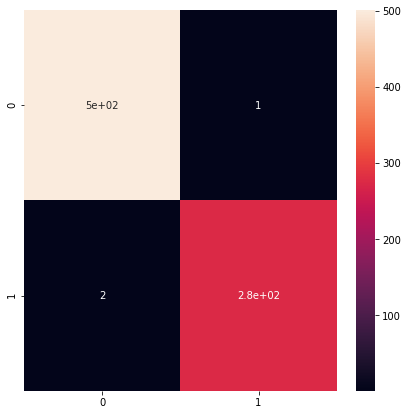

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       502
           1       1.00      0.99      0.99       278

   micro avg       1.00      1.00      1.00       780
   macro avg       1.00      1.00      1.00       780
weighted avg       1.00      1.00      1.00       780



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


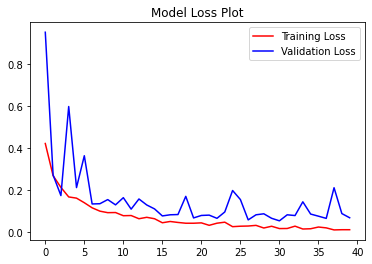

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'Training Loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'Validation Loss')
plt.title('Model Loss Plot')
plt.legend()
plt.show()

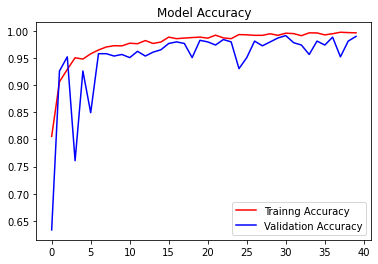

In [ ]:
plt.plot(history.history['accuracy'], color = 'red', label = 'Trainng Accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# LET'S BUILD A SEGMENTATION MODEL TO LOCALIZE TUMOR. THAT IS TO SHOW THE LOCATION OF THE TUMOR IN THE IMAGE

In [ ]:
# we Reload our MRI brain tumor datafram
brain_df_seg = pd.read_csv('data_mask.csv')
brain_df_seg.head()

patient_id  ... mask
0  TCGA_CS_5395_19981004  ...    0
1  TCGA_CS_5395_19981004  ...    0
2  TCGA_CS_5395_19981004  ...    0
3  TCGA_CS_5395_19981004  ...    0
4  TCGA_CS_5395_19981004  ...    0

[5 rows x 4 columns]

In [ ]:
# Get the dataframe containing MRIs which have masks associated with them. Enssencuall, unhealthy MRI images
brain_df_mask = brain_df_seg[brain_df_seg['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.1)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# create separate list for imageId, classId to pass into the generator
# because we are going to train our model on input and output. The input will be our MRI image and 
# the output will be the mask
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

### Building a (Resudual Block) Resblock and Upsampling layer

In [ ]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),
             kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1),
            padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1),
                  kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together. This will later generate an output for us when we actuall built our UNet segmentation model

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:

# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

### Now after building our Residual block and the Upsampling, we are ready now to build our ResuNet Network

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)


#CONTRACTION OR ENCODING PARTH
# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)

conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)

pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)


# THE BOTTLENECT PATH
# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)


# EXPANSIVE OR DECODING PATH
# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
# Here is the final stage of our UNet and it make sure that the output has the same size as the input.
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
model_seg.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

### Now let's train the Resunet segmentation model to localize the tumor

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
# We used this loss function because we want to perform pixel level classification
from utilities import focal_tversky, tversky_loss, tversky

def focal_tversky(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_true = tf.cast(y_pred, tf.float32)

  pt_1 = tversky(y_true, y_pred)
  gamma = 0.75
  return K.pow((1-pt_1), gamma)
  

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.001, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, 
                   metrics = [tversky])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min',
                              verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history1 = model_seg.fit(training_generator, epochs = 50, 
                      validation_data = validation_generator,
                   callbacks = [checkpointer, earlystopping])

Epoch 1/50
77/77 [==============================] - 803s 10s/step - loss: 0.4517 - tversky: 0.0602 - val_loss: 0.4978 - val_tversky: 0.0654

Epoch 00001: val_loss improved from inf to 0.49782, saving model to ResUNet-weights.hdf5
Epoch 2/50
77/77 [==============================] - 18s 236ms/step - loss: 0.3884 - tversky: 0.0472 - val_loss: 0.3889 - val_tversky: 0.0551

Epoch 00002: val_loss improved from 0.49782 to 0.38890, saving model to ResUNet-weights.hdf5
Epoch 3/50
77/77 [==============================] - 15s 195ms/step - loss: 0.3184 - tversky: 0.0379 - val_loss: 0.3140 - val_tversky: 0.0423

Epoch 00003: val_loss improved from 0.38890 to 0.31398, saving model to ResUNet-weights.hdf5
Epoch 4/50
77/77 [==============================] - 14s 187ms/step - loss: 0.2733 - tversky: 0.0306 - val_loss: 0.2715 - val_tversky: 0.0321

Epoch 00004: val_loss improved from 0.31398 to 0.27148, saving model to ResUNet-weights.hdf5
Epoch 5/50
77/77 [==============================] - 14s 184ms/ste

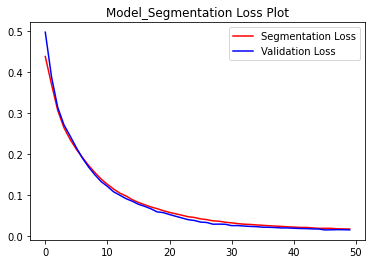

In [ ]:
plt.plot(history1.history['loss'], color = 'red', label = 'Segmentation Loss')
plt.plot(history1.history['val_loss'], color = 'blue', label = 'Validation Loss')
plt.title('Model_Segmentation Loss Plot')
plt.legend()
plt.show()


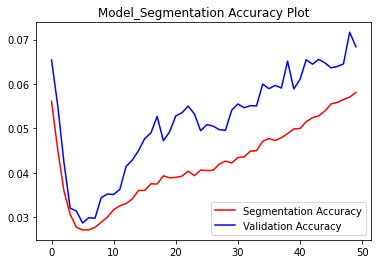

In [ ]:
plt.plot(history1.history['tversky'], color = 'red', label = 'Segmentation Accuracy')
plt.plot(history1.history['val_tversky'], color = 'blue', label = 'Validation Accuracy')
plt.title('Model_Segmentation Accuracy Plot')
plt.legend()
plt.show()


In [ ]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

## ASSESS TRAINED SEGMENTATION RESUNET MODEL PERFORMANCE

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction 
# The prediction function is going to run the entire pipeline for us.
# it is going to make prediction on our testing data.  In essence, we give it our original AlexNet model and a testing data .

# making prediction
image_id, mask, has_mask = prediction(test, AlexNet, model_seg)
#print(f'The accuracy is {image_id, mask, has_mask*100.:2f}%')

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  ... has_mask
0    TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_22...  ...        0
1    TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_17...  ...        0
2    TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_27...  ...        0
3    TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_30...  ...        1
4    TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_24...  ...        0
..                                                 ...  ...      ...
388  TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_27...  ...        1
389  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_51...  ...        0
390  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_31...  ...        1
391  TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_21...  ...        1
392  TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_18...  ...        1

[393 rows x 3 columns]

In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  ... has_mask
0  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_22...  ...        0
1  TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_17...  ...        0
2  TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_27...  ...        0
3  TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_30...  ...        1
4  TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_24...  ...        0

[5 rows x 5 columns]

In [ ]:
count = 0 
fig, axs = plt.subplots(15, 5, figsize=(20, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 15:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

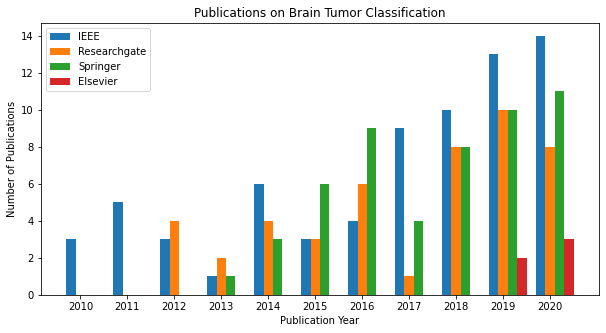

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
w = 0.2 
plt.figure(figsize=(10,5))  
X = [2010,2011,2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
IEEE = [3,5,3,1,6,3,4,9,10,13,14]
Researchgate = [0,0,4,2,4,3,6,1,8,10,8]
Springer=[0,0,0,1,3,6,9,4,8,10,11]
Elsevier = [0,0,0,0,0,0,0,0,0,2,3]
  
#X_axis = np.arange(len(X))
bar1 = np.arange(len(X))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 =[i+w for i in bar3]
  
plt.bar(bar1,  IEEE, w, label = 'IEEE')
plt.bar(bar2,  Researchgate, w,label = 'Researchgate')
plt.bar(bar3,  Springer ,w,label = 'Springer')
plt.bar(bar4,  Elsevier,w,label = 'Elsevier')

plt.xlabel("Publication Year")
plt.ylabel("Number of Publications")
plt.title("Publications on Brain Tumor Classification")
plt.xticks(bar1+w, X)
plt.legend()
plt.show()